## I. Importación de Librerías y Configuración Inicial

In [1]:
import os
import glob
import json
import re
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import spacy
from transformers import pipeline

c:\Users\Jesus\anaconda3\envs\sentiment_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download('punkt')
nltk.download('stopwords')

try:
    nlp = spacy.load('es_core_news_sm')
except Exception as e:
    print("No se pudo cargar el modelo de spaCy para español.")

# Se definen las stopwords en español
STOP_WORDS = set(stopwords.words('spanish'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## II. Cargar los datos | Preprocesamiento de Datos

### Funciones

In [5]:
def load_json_files(directory_path):
    """Carga todos los archivos JSON"""
    file_pattern = os.path.join(directory_path, "*.json")
    files = glob.glob(file_pattern)
    data = []
    for file in files:
        try:
            with open(file, 'r', encoding='utf-8') as f:
                file_data = json.load(f)
                data.extend(file_data)
            print(f"Archivo cargado: {file}")
        except Exception as e:
            print(f"Error al leer {file}: {e}")
    return data

def clean_text(text):
    """
    Limpia el texto:
      - Elimina etiquetas HTML.
      - Remueve caracteres no alfabéticos (se conservan acentos y ñ).
      - Convierte a minúsculas.
      - Tokeniza y lematiza usando spaCy.
      - Elimina stopwords.
    """
    text = re.sub(r'<.*?>', '', text)  # Eliminar HTML
    text = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑ\s]', '', text)  # Solo letras y espacios
    text = text.lower()
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc 
              if token.text not in STOP_WORDS and not token.is_punct and not token.is_space]
    return " ".join(tokens)

def combine_and_clean(row):
    """Combina las columnas 'direct_snippet' y 'full_content' y aplica la limpieza."""
    direct = row.get('direct_snippet', '')
    full = row.get('full_content', '')
    combined = f"{direct} {full}"
    return clean_text(combined)


In [4]:
def extract_pos_tags(text):
    """Extrae las etiquetas POS (part-of-speech) de cada token en el texto usando spaCy"""
    doc = nlp(text)
    return [(token.text, token.pos_) for token in doc]

def extract_entities(text):
    """Extrae las entidades nombradas del texto usando spaCy"""
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

In [3]:
def get_spacy_embeddings(text):
    doc = nlp(text)
    return doc.vector

### Carga de Datos y Creación del DataFrame


In [6]:
data_directory = '../Data'

# Cargar datos desde todos los archivos JSON
data = load_json_files(data_directory)
df = pd.DataFrame(data)
print(f"Total de registros cargados: {df.shape[0]}")

df.head()

Archivo cargado: ../Data\data_extracted_topic_1_12022025.json
Archivo cargado: ../Data\data_extracted_topic_2_12022025.json
Archivo cargado: ../Data\data_extracted_topic_3_12022025.json
Archivo cargado: ../Data\results_variations.json
Total de registros cargados: 1907


,query,direct_snippet,url,full_title,full_content
0,¿Qué nivel de aprobación tiene actualmente la ...,César Acuña resaltó que la aprobación de la pr...,https://larepublica.pe/sociedad/2024/12/02/nom...,[Error] Web request failed: 403 Client Error: ...,"El gobernador regional de La Libertad, César A..."
1,¿Qué nivel de aprobación tiene actualmente la ...,"La presidenta de la República, Dina Boluarte, ...",https://peru21.pe/politica/dina-boluarte-vuelv...,[Error] Web request failed: 403 Client Error: ...,"La presidenta de la República, Dina Boluarte, ..."
2,¿Qué nivel de aprobación tiene actualmente la ...,La presidenta Dina Boluarte enfrenta una grave...,https://larepublica.pe/politica/2024/12/25/din...,[Error] Web request failed: 403 Client Error: ...,Dina Boluarte enfrenta récords negativos de ap...
3,¿Qué nivel de aprobación tiene actualmente la ...,Dina Boluarte espera que otra mujer sea elegid...,https://www.infobae.com/peru/2025/02/11/dina-b...,Dina Boluarte espera que otra mujer sea elegid...,Dina Boluarte espera que otra mujer sea elegid...
4,¿Qué nivel de aprobación tiene actualmente la ...,"La aprobación de la presidenta de Perú, ... el...",https://actualidad.rt.com/actualidad/530748-ap...,La aprobación de Dina Boluarte cae a mínimos h...,La aprobación de Dina Boluarte cae a mínimos h...


In [7]:
# Combinar las columnas para tener mayor cantidad de oraciones
df['combined_text'] = df['direct_snippet'].fillna('') + " " + df['full_content'].fillna('')

In [8]:
# Aplicar la limpieza al texto combinado
df['clean_text'] = df.apply(combine_and_clean, axis=1)
print("Texto combinado y limpieza completados.")

Texto combinado y limpieza completados.


In [9]:
# Visualizar un ejemplo
print(df[['direct_snippet', 'full_content', 'combined_text', 'clean_text']].head())

                                      direct_snippet  \
0  César Acuña resaltó que la aprobación de la pr...   
1  La presidenta de la República, Dina Boluarte, ...   
2  La presidenta Dina Boluarte enfrenta una grave...   
3  Dina Boluarte espera que otra mujer sea elegid...   
4  La aprobación de la presidenta de Perú, ... el...   

                                        full_content  \
0  El gobernador regional de La Libertad, César A...   
1  La presidenta de la República, Dina Boluarte, ...   
2  Dina Boluarte enfrenta récords negativos de ap...   
3  Dina Boluarte espera que otra mujer sea elegid...   
4  La aprobación de Dina Boluarte cae a mínimos h...   

                                       combined_text  \
0  César Acuña resaltó que la aprobación de la pr...   
1  La presidenta de la República, Dina Boluarte, ...   
2  La presidenta Dina Boluarte enfrenta una grave...   
3  Dina Boluarte espera que otra mujer sea elegid...   
4  La aprobación de la presidenta de Perú, ...

## III. Análisis de Sentimientos

### A) Análisis de Sentimientos con VADER

In [10]:
analyzer = SentimentIntensityAnalyzer()
df['vader_score'] = df['combined_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df['vader_sentiment'] = df['vader_score'].apply(lambda x: 'positive' if x > 0.2 else ('negative' if x < -0.2 else 'neutral'))
print("Análisis de sentimientos con VADER completado.")

Análisis de sentimientos con VADER completado.


In [11]:
# Conteo de sentimientos
vader_counts = df['vader_sentiment'].value_counts()
print("Conteo de Sentimientos (VADER):")
print(vader_counts)

Conteo de Sentimientos (VADER):
vader_sentiment
negative    1328
positive     352
neutral      227
Name: count, dtype: int64


C:\Users\Jesus\AppData\Local\Temp\ipykernel_29284\1234582769.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='vader_sentiment', data=df, order=['negative', 'neutral', 'positive'], palette='coolwarm')


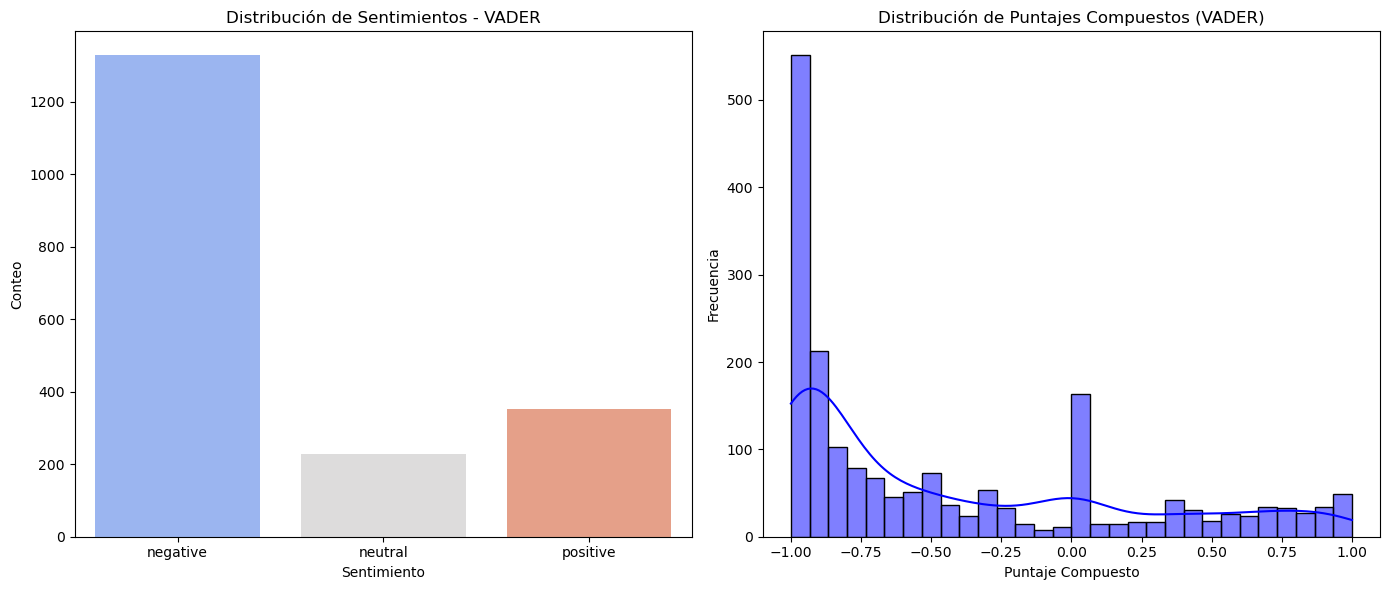

In [12]:

plt.figure(figsize=(14, 6))

# Gráfico de barras de la distribución (VADER)
plt.subplot(1, 2, 1)
sns.countplot(x='vader_sentiment', data=df, order=['negative', 'neutral', 'positive'], palette='coolwarm')
plt.title("Distribución de Sentimientos - VADER")
plt.xlabel("Sentimiento")
plt.ylabel("Conteo")

# Histograma del score compuesto
plt.subplot(1, 2, 2)
sns.histplot(df['vader_score'], bins=30, kde=True, color='blue')
plt.title("Distribución de Puntajes Compuestos (VADER)")
plt.xlabel("Puntaje Compuesto")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

In [13]:
print("Estadísticas de Puntaje Compuesto (VADER):")
print(df['vader_score'].describe())

Estadísticas de Puntaje Compuesto (VADER):
count    1907.000000
mean       -0.439599
std         0.612865
min        -1.000000
25%        -0.948000
50%        -0.718400
75%         0.000000
max         0.999900
Name: vader_score, dtype: float64


### B) Análisis de Sentimientos con Hugging Face (?)

## IV. Extracción de Patrones e Insights Adicionales

### A) POS Tagging

In [ ]:
# Se extraen las etiquetas POS de cada texto
df['pos_tags'] = df['clean_text'].apply(lambda text: extract_pos_tags(text))

# Extraer todas las etiquetas
all_pos = []
for tags in df['pos_tags']:
    all_pos.extend([pos for (_, pos) in tags])

pos_counts = Counter(all_pos)
print("Conteo de etiquetas POS:", pos_counts)

Conteo de etiquetas POS: Counter({'NOUN': 289679, 'ADJ': 229483, 'VERB': 180689, 'PROPN': 156547, 'ADV': 27776, 'AUX': 14790, 'ADP': 11279, 'PRON': 9249, 'DET': 8083, 'NUM': 6609, 'SCONJ': 4065, 'CCONJ': 2452, 'INTJ': 116, 'SYM': 97, 'SPACE': 90, 'PUNCT': 43, 'PART': 26})


C:\Users\Jesus\AppData\Local\Temp\ipykernel_29284\658837956.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(pos_counts.keys()), y=list(pos_counts.values()), palette="mako")


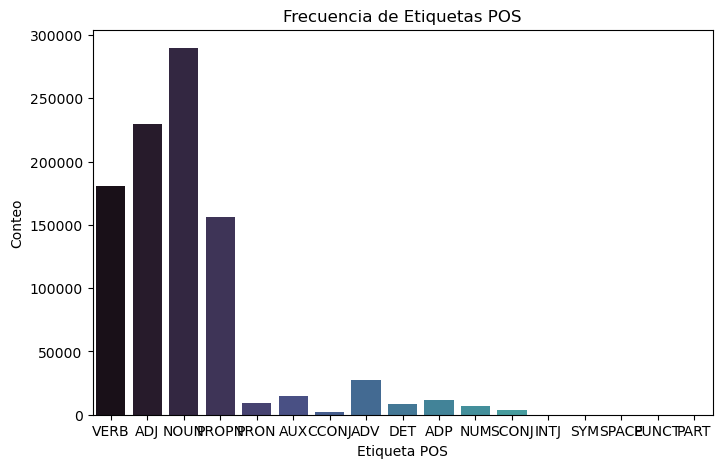

In [15]:
plt.figure(figsize=(8,5))
sns.barplot(x=list(pos_counts.keys()), y=list(pos_counts.values()), palette="mako")
plt.title("Frecuencia de Etiquetas POS")
plt.xlabel("Etiqueta POS")
plt.ylabel("Conteo")
plt.show()

### B) Named Entity Recognition (NER)

In [16]:
df['entities'] = df['full_content'].apply(lambda text: extract_entities(text))
# Mostrar ejemplos de entidades extraídas
print(df[['full_title', 'entities']].head())

                                          full_title  \
0  [Error] Web request failed: 403 Client Error: ...   
1  [Error] Web request failed: 403 Client Error: ...   
2  [Error] Web request failed: 403 Client Error: ...   
3  Dina Boluarte espera que otra mujer sea elegid...   
4  La aprobación de Dina Boluarte cae a mínimos h...   

                                            entities  
0  [(La Libertad, LOC), (César Acuña, PER), (Año ...  
1  [(República, MISC), (Dina Boluarte, LOC), (Est...  
2  [(Dina Boluarte, PER), (¿Cómo, MISC), (Composi...  
3  [(Dina Boluarte, PER), (Perú, ORG), (Eleccione...  
4  [(Dina Boluarte, PER), (Perú, LOC), (Perú, PER...  


In [21]:
# Extraer todas las entidades
all_entities = []
for ents in df['entities']:
    all_entities.extend(ents)

In [20]:
# Contar la frecuencia de cada entidad
entity_texts = [entity for (entity, label) in all_entities]
entity_counts = Counter(entity_texts)

print("Top 10 entidades nombradas:")
for entity, count in entity_counts.most_common(10):
    print(f"{entity}: {count}")

Top 10 entidades nombradas:
Dina Boluarte: 4598
Boluarte: 2396
Perú: 2321
Congreso: 1464
Qali Warma: 1196
Lima: 1050
Estado: 984
Gobierno: 929
Además: 892
Estados Unidos: 760


In [22]:
# Agrupar las entidades por etiqueta
entity_by_label = {}
for entity, label in all_entities:
    if label in entity_by_label:
        entity_by_label[label].append(entity)
    else:
        entity_by_label[label] = [entity]
        
print("\nConteo de entidades por etiqueta:")
for label, entities in entity_by_label.items():
    print(f"{label}: {len(entities)}")


Conteo de entidades por etiqueta:
LOC: 39083
PER: 37344
MISC: 43217
ORG: 16122


C:\Users\Jesus\AppData\Local\Temp\ipykernel_29284\2713501687.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(entities), y=list(counts), palette='viridis')


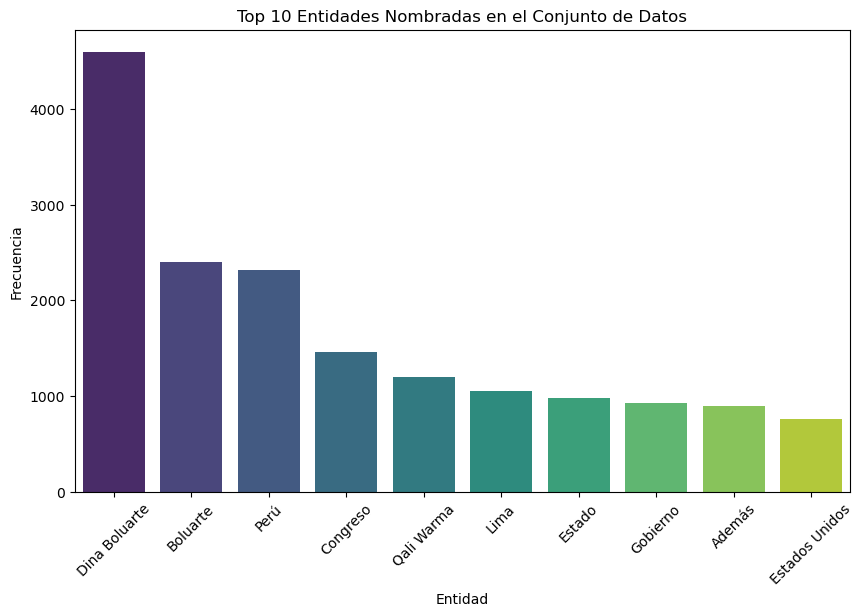

In [23]:
# Visualización: Top 10 entidades globales
top_entities = entity_counts.most_common(10)
entities, counts = zip(*top_entities)
plt.figure(figsize=(10,6))
sns.barplot(x=list(entities), y=list(counts), palette='viridis')
plt.title("Top 10 Entidades Nombradas en el Conjunto de Datos")
plt.xlabel("Entidad")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.show()

## Representación de Textos

### A) TF-IDF

In [17]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])
print("Vectorización TF-IDF completada.")

Vectorización TF-IDF completada.


### B) Embeddings con spaCy

## Modelo Supervisado: Clasificación [Random Forest(?)]